<h1 style="text-align: center; font-family: Arial, sans-serif; color: #1e90ee; font-weight: bold; padding: 20px; border-bottom: 2px solid #1e90ff;">
    DataFest Hackathon 2024
</h1>
<h2 style="text-align: center; font-family: Arial, sans-serif; color: #1e90ff; font-weight: bold; margin-top: 10px;">
    Team XGBoost's Data Science Solution
</h2>

<h3 style="text-align: center; font-family: Arial, sans-serif; color: #fffff; font-weight: bold; margin-top: 20px;">
    Objectives
</h3>
<ul style="font-family: Arial, sans-serif; color: #fffff; line-height: 1.6; padding: 20px; list-style-type: disc;">
    <li>Identify possible problems students might be facing while writing these exams, bearing in mind that this would involve starting from scratch as most schools do not have the foundational data infrastructure to solve this problem.</li>
    <li>Generate your data through any means based on the needs of your solution while ensuring that your data adequately reflects the state of the African education ecosystem.</li>
    <li>Design an enterprise data solution for the school’s data collection, pipelining, warehousing, automation, and reporting needs.</li>
    <li>Create an optimized model that predicts the likelihood of a student passing or failing their upcoming exam based on their academic history. Consider all factors that could affect a student's upcoming result aside from their previous exam scores.</li>
    <li>Make relevant recommendations to the stakeholders on how they can help improve the performance of the students based on your solution.</li>
</ul>

<h3 style="text-align: left; font-family: Arial, sans-serif; color: #fffff; font-weight: bold; margin-top: 20px;">
    Data Loading & Importing Libraries
</h3>
<p style="font-family: Arial, sans-serif; color: #fffff; line-height: 1.6; padding: 10px;">
    In this section, we will load the necessary libraries and datasets required for our analysis and modeling. These libraries include tools for data manipulation, visualization, and machine learning.
</p>

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [2]:
from time import time
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
sns.set_theme(style='white', palette='muted', font_scale=0.9)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score, classification_report, precision_score, recall_score
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from astropy.table import Table

# CATBOOST MODEL
from catboost import CatBoostClassifier, Pool
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from catboost.utils import eval_metric
import logging

<h3 style="text-align: left; font-family: Arial, sans-serif; color: #fffff; font-weight: bold; margin-top: 20px;">
    Data Loading
</h3>
<p style="font-family: Arial, sans-serif; color: #fffff; line-height: 1.6; padding: 10px;">
     collecting the data from the Snowflake warehouse
</p>

In [ ]:
!pip install snowflake-connector-python[pandas]

!pip install snowflake-U

!pip install --upgrade snowflake-sqlalchemy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement snowflake-U (from versions: none)
ERROR: No matching distribution found for snowflake-U
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
import snowflake.connector
import getpass

In [ ]:
# Prompt for to enter secrets securely
user = getpass.getpass(prompt='Enter your Snowflake username: ')
password = getpass.getpass(prompt='Enter your Snowflake password: ')

Enter your Snowflake username: ··········
Enter your Snowflake password: ··········


In [ ]:
# Establish the connection using the masked password
ctx = snowflake.connector.connect(
    user=user,
    password=password,
    account='sp14512.eu-central-2.aws',
    warehouse='Dbt_Datathon_Wh',
    database='DBT_SEC_SCHOOL_DB',
    schema='DBT_SEC_SCHOOL_SCHEMA'
)

In [ ]:
user, password

('Adun', 'Team_xgboost2024!')

In [ ]:
# Create a cursor object
cur = ctx.cursor()

In [ ]:
# Fetch DimStaff
cur.execute("SELECT * FROM DBT_SEC_SCHOOL_DB.DBT_SEC_SCHOOL_SCHEMA.DIMSTAFF")
# Fetch and print the result
DimStaff = cur.fetch_pandas_all()
print("DimStaff")
display(DimStaff.head())

# Fetch DimStudent
cur.execute("SELECT * FROM DBT_SEC_SCHOOL_DB.DBT_SEC_SCHOOL_SCHEMA.DIMSTUDENT")
DimStudent = cur.fetch_pandas_all()
print("DimStudent")
display(DimStudent.head())

# Fetch DimFamily
cur.execute("SELECT * FROM DBT_SEC_SCHOOL_DB.DBT_SEC_SCHOOL_SCHEMA.DIMFAMILY")
DimFamily = cur.fetch_pandas_all()
print("DimFamily")
display(DimFamily.head())

# Fetch FactAcadPerf
cur.execute("SELECT * FROM DBT_SEC_SCHOOL_DB.DBT_SEC_SCHOOL_SCHEMA.FACTACADEMICPERFORMANCE")
FactAcadPerf = cur.fetch_pandas_all()
print("FactAcadPerf")
display(FactAcadPerf.head())

# Fetch FactXtraCur
cur.execute("SELECT * FROM DBT_SEC_SCHOOL_DB.DBT_SEC_SCHOOL_SCHEMA.FACTEXTRACURRICULAR")
FactXtraCur = cur.fetch_pandas_all()
print("FactXtraCur")
display(FactXtraCur.head())

# Fetch FactResUsage
cur.execute("SELECT * FROM DBT_SEC_SCHOOL_DB.DBT_SEC_SCHOOL_SCHEMA.FACTRESOURCEUSAGE")
FactResUsage = cur.fetch_pandas_all()
print("FactResUsage")
display(FactResUsage.head())

DimStaff


,STAFF_ID,FULL_NAME,SUBJECT_TAUGHT,QUALIFICATION,YEARS_OF_EXPERIENCE,DATE_JOINED,EMAIL,ROLE_TYPE,JOB_TITLE,IS_ACTIVE
0,201,Adebayo Adewale,English Language,M.Ed,6,2022-09-09,adebayo.adewale@fgcilorin.edu.ng,Teaching,Class Teacher,True
1,202,Bamgboye Eniola,English Language,B.Ed,13,2010-06-24,bamgboye.eniola@fgcilorin.edu.ng,Teaching,Senior Teacher,True
2,203,Meggision Alero,English Language,M.Ed,18,2018-01-09,meggision.alero@fgcilorin.edu.ng,Teaching,Head of Department,True
3,204,Chinaza Nwachukwu,Mathematics,B.Ed,5,2020-06-25,chinaza.nwachukwu@fgcilorin.edu.ng,Teaching,Senior Teacher,True
4,205,Ozigbo Chidera,Mathematics,B.Ed,11,2017-11-06,ozigbo.chidera@fgcilorin.edu.ng,Teaching,Class Teacher,True


DimStudent


,STUDENT_ID,ADMISSION_NUMBER,FULL_NAME,DATE_OF_BIRTH,GENDER,JOIN_DATE,JOIN_CLASS,CURRENT_CLASS,DISCIPLINE,GRADUATION_DATE,STATE_OF_ORIGIN,RELIGION,BOARDING_STATUS,SCHOLARSHIP_TYPE,HEALTH_INFORMATION,DISTANCE_TO_SCHOOL_KM,TRANSPORT_MODE
0,1001,JS1A/2019/001,Aisha Ibrahim,2006-07-21,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Day Student,Need-based,Asthma,5.44,Walk
1,1002,JS1A/2019/002,Olivia Lee,2006-06-03,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Lagos,Christianity,Day Student,Need-based,Asthma,6.14,Walk
2,1003,JS1A/2019/003,Emeka Ali,2005-04-23,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Boarder,None,Healthy,None,None
3,1004,JS1A/2019/004,Aisha Okafor,2006-12-15,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Oyo,Christianity,Boarder,Need-based,Healthy,None,None
4,1005,JS1A/2019/005,Fatima Abdullahi,2005-03-26,Female,2019-09-15,JS1A,SS3A,Art,2024-07-15,Lagos,Christianity,Day Student,Need-based,Asthma,7.95,Bicycle


DimFamily


,FAMILY_ID,SOCIOECONOMIC_STATUS,PARENT_EDUCATION_LEVEL,NUMBER_OF_SIBLINGS,FAMILY_STRUCTURE
0,5001,Upper,Tertiary,1,Both parents
1,5002,Middle,Primary,5,Single parent
2,5003,Lower,Primary,2,Both parents
3,5004,Lower,Tertiary,2,Single parent
4,5005,Upper,Secondary,3,Single parent


FactAcadPerf


,PERFORMANCE_ID,STUDENT_ID,YEAR,CLASS_NAME,SUBJECT,TOTAL_SCORE,TEACHER_ID,FAMILY_ID,TOTAL_ATTENDANCE,SCORE_RANGE
0,1,1001,2019,JS1A,Mathematics,52,204,5001,164,50-59
1,2,1001,2019,JS1A,English Language,60,201,5001,158,60-69
2,3,1001,2019,JS1A,Civic Education,33,216,5001,121,30-39
3,4,1001,2019,JS1A,Basic Science,42,207,5001,144,40-49
4,5,1001,2019,JS1A,Basic Technology,56,210,5001,179,50-59


FactXtraCur


,EXTRACURRICULAR_ID,STUDENT_ID,ACTIVITY_NAME,ACTIVITY_DATE,DURATION_MINUTES,INSTRUCTOR
0,1,1001,Drama,2023-01-22,120,206
1,2,1001,Debate,2023-04-15,90,207
2,3,1001,Music Club,2023-10-27,90,207
3,4,1002,Drama,2023-06-10,90,201
4,5,1003,Football,2023-09-02,120,208


FactResUsage


,USAGE_ID,STUDENT_ID,RESOURCE_NAME,USAGE_DATE,START_TIME,DURATION_MINUTES,PURPOSE,SUPERVISED_BY
0,1,1001,Computer Lab,2023-05-29,10:00:00,60,Study,223
1,2,1001,Computer Lab,2023-03-12,12:30:00,30,Practical,227
2,3,1002,Computer Lab,2023-07-13,10:00:00,45,Research,239
3,4,1002,Science Lab,2023-02-04,10:00:00,60,Study,206
4,5,1002,Computer Lab,2023-12-15,10:00:00,45,Practical,206


In [3]:
DimStaff = pd.read_csv("/content/DimStaff.csv")
# DimStaff = pd.read_csv(r"C:\Users\Dell\Desktop\Client Projects\DataFest Africa 2024\Datathon\DimStaff.csv")
print(DimStaff.shape)
display(DimStaff.head())

DimStudent = pd.read_csv("/content/DimStudent.csv")
# DimStudent = pd.read_csv(r"C:\Users\Dell\Desktop\Client Projects\DataFest Africa 2024\Datathon\DimStudent.csv")
print(DimStudent.shape)
display(DimStudent.head())

DimFamily = pd.read_csv("/content/Dimfamily_data.csv")
# Dimfamily_data = pd.read_csv(r"C:\Users\Dell\Desktop\Client Projects\DataFest Africa 2024\Datathon\Dimfamily_data.csv")
print(DimFamily.shape)
display(DimFamily.head())

FactAcadPerf = pd.read_csv("/content/FactAcademicPerformance_with_attendance.csv")
# FactAcadPerf = pd.read_csv(r"C:\Users\Dell\Desktop\Client Projects\DataFest Africa 2024\Datathon\FactAcademicPerformance7.csv")
print(FactAcadPerf.shape)
FactAcadPerf.head()

FactXtraCur = pd.read_csv("/content/FactExtracurricular.csv")
# FactXtraCur = pd.read_csv(r"C:\Users\Dell\Desktop\Client Projects\DataFest Africa 2024\Datathon\FactExtracurricular.csv")
print(FactXtraCur.shape)
FactXtraCur.head()

FactResUsage = pd.read_csv("/content/FactResourceUsage.csv")
# FactResUsage = pd.read_csv(r"C:\Users\Dell\Desktop\Client Projects\DataFest Africa 2024\Datathon\FactResourceUsage.csv")
print(FactResUsage.shape)
FactResUsage.head()

(50, 10)


,staff_id,full_name,subject_taught,qualification,years_experience,date_joined,email,role_type,job_title,is_active
0,201,Adebayo Adewale,English Language,M.Ed,6,9/9/22,adebayo.adewale@fgcilorin.edu.ng,Teaching,Senior Teacher,True
1,202,Bamgboye Eniola,English Language,B.Ed,13,6/24/10,bamgboye.eniola@fgcilorin.edu.ng,Teaching,Class Teacher,True
2,203,Meggision Alero,English Language,M.Ed,18,1/9/18,meggision.alero@fgcilorin.edu.ng,Teaching,Head of Department,True
3,204,Chinaza Nwachukwu,Mathematics,B.Ed,5,6/25/20,chinaza.nwachukwu@fgcilorin.edu.ng,Teaching,Senior Teacher,True
4,205,Ozigbo Chidera,Mathematics,B.Ed,11,11/6/17,ozigbo.chidera@fgcilorin.edu.ng,Teaching,Class Teacher,True


(300, 18)


,student_id,admission_number,full_name,date_of_birth,gender,join_date,join_class,current_class,discipline,graduation_date,state_of_origin,religion,boarding_status,scholarship_type,health_information,distance_to_school_km,transport_mode,family_id
0,1001,JS1A/2019/001,Aisha Ibrahim,2006-07-21,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Day Student,Need-based,Asthma,5.44,Walk,5001
1,1002,JS1A/2019/002,Olivia Lee,2006-06-03,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Lagos,Christianity,Day Student,Need-based,Asthma,6.14,Walk,5002
2,1003,JS1A/2019/003,Emeka Ali,2005-04-23,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Boarder,NaN,Healthy,NaN,NaN,5003
3,1004,JS1A/2019/004,Aisha Okafor,2006-12-15,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Oyo,Christianity,Boarder,Need-based,Healthy,NaN,NaN,5004
4,1005,JS1A/2019/005,Fatima Abdullahi,2005-03-26,Female,2019-09-15,JS1A,SS3A,Art,2024-07-15,Lagos,Christianity,Day Student,Need-based,Asthma,7.95,Bicycle,5005


(100, 5)


,family_id,socioeconomic_status,parent_education_level,number_of_siblings,family_structure
0,5001,Upper,Tertiary,1,Both parents
1,5002,Middle,Primary,5,Single parent
2,5003,Lower,Primary,2,Both parents
3,5004,Lower,Tertiary,2,Single parent
4,5005,Upper,Secondary,3,Single parent


(9000, 10)
(150, 6)
(300, 8)


,usage_id,student_id,resource_name,usage_date,start_time,duration_minutes,purpose,supervised_by
0,30001,1008,Computer Lab,2023-10-25,10:00:00,45,Practical,203
1,30002,1187,Science Lab,2023-06-28,10:00:00,45,Study,207
2,30003,1130,Library,2023-06-15,10:00:00,60,Research,209
3,30004,1102,Library,2023-05-31,12:30:00,45,Practical,201
4,30005,1018,Computer Lab,2023-07-09,10:00:00,45,Study,206


In [4]:
FactXtraCur.columns

Index(['extracurricular_id', 'student_id', 'activity_name', 'activity_date',
       'duration_minutes', 'instructor'],
      dtype='object')

<h2 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
    Data Wrangling
</h2>

<h3 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
    Renaming column names to lowercase
</h3>

In [5]:
DimStaff.columns = DimStaff.columns.str.lower(); DimStudent.columns = DimStudent.columns.str.lower(); DimFamily.columns = DimFamily.columns.str.lower(); FactAcadPerf.columns = FactAcadPerf.columns.str.lower(); FactXtraCur.columns = FactXtraCur.columns.str.lower(); FactResUsage.columns = FactResUsage.columns.str.lower()

<h3 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
    Transformation of Date Columns
</h3>

In [6]:
# Convert date columns to datetime format
DimStaff['date_joined'] = pd.to_datetime(DimStaff['date_joined'])
DimStaff['date_joined'] = pd.to_datetime(DimStaff['date_joined'], format='%Y-%m-%d')

DimStudent['date_of_birth'] = pd.to_datetime(DimStudent['date_of_birth'])
DimStudent['join_date'] = pd.to_datetime(DimStudent['join_date'])
DimStudent['graduation_date'] = pd.to_datetime(DimStudent['graduation_date'])

<ipython-input-6-525564b884ad>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DimStaff['date_joined'] = pd.to_datetime(DimStaff['date_joined'])


<h3 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
    Merge Tables
</h3>

In [7]:
DimStudent.head(2)

,student_id,admission_number,full_name,date_of_birth,gender,join_date,join_class,current_class,discipline,graduation_date,state_of_origin,religion,boarding_status,scholarship_type,health_information,distance_to_school_km,transport_mode,family_id
0,1001,JS1A/2019/001,Aisha Ibrahim,2006-07-21,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Day Student,Need-based,Asthma,5.44,Walk,5001
1,1002,JS1A/2019/002,Olivia Lee,2006-06-03,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Lagos,Christianity,Day Student,Need-based,Asthma,6.14,Walk,5002


In [8]:
DimFamily.head(2)

,family_id,socioeconomic_status,parent_education_level,number_of_siblings,family_structure
0,5001,Upper,Tertiary,1,Both parents
1,5002,Middle,Primary,5,Single parent


In [9]:
FactAcadPerf.rename(columns={'teacher_id': 'staff_id'}, inplace=True)

In [10]:
# merging the DimSTudent column with Dim Family Data

df = DimStudent.merge(DimFamily, on='family_id', how='left')
df=df.merge(FactAcadPerf, on='student_id', how='left')
df=df.merge(DimStaff, on='staff_id', how='left')
df.head()

,student_id,admission_number,full_name_x,date_of_birth,gender,join_date,join_class,current_class,discipline,graduation_date,state_of_origin,religion,boarding_status,scholarship_type,health_information,distance_to_school_km,transport_mode,family_id_x,socioeconomic_status,parent_education_level,number_of_siblings,family_structure,performance_id,year,class_name,subject,total_score,staff_id,family_id_y,total_attendance,score_range,full_name_y,subject_taught,qualification,years_experience,date_joined,email,role_type,job_title,is_active
0,1001,JS1A/2019/001,Aisha Ibrahim,2006-07-21,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Day Student,Need-based,Asthma,5.44,Walk,5001,Upper,Tertiary,1,Both parents,1,2019,JS1A,Mathematics,52,204,5001,164,50-59,Chinaza Nwachukwu,Mathematics,B.Ed,5.0,2020-06-25,chinaza.nwachukwu@fgcilorin.edu.ng,Teaching,Senior Teacher,True
1,1001,JS1A/2019/001,Aisha Ibrahim,2006-07-21,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Day Student,Need-based,Asthma,5.44,Walk,5001,Upper,Tertiary,1,Both parents,2,2019,JS1A,English Language,60,201,5001,158,60-69,Adebayo Adewale,English Language,M.Ed,6.0,2022-09-09,adebayo.adewale@fgcilorin.edu.ng,Teaching,Senior Teacher,True
2,1001,JS1A/2019/001,Aisha Ibrahim,2006-07-21,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Day Student,Need-based,Asthma,5.44,Walk,5001,Upper,Tertiary,1,Both parents,3,2019,JS1A,Civic Education,33,216,5001,121,30-39,Emmanuel Obi,Civic Education,M.Ed,8.0,2013-06-05,emmanuel.obi@fgcilorin.edu.ng,Teaching,Head of Department,True
3,1001,JS1A/2019/001,Aisha Ibrahim,2006-07-21,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Day Student,Need-based,Asthma,5.44,Walk,5001,Upper,Tertiary,1,Both parents,4,2019,JS1A,Basic Science,42,207,5001,144,40-49,Fatimah Yusuf,Basic Science,B.Ed,1.0,2021-05-08,fatimah.yusuf@fgcilorin.edu.ng,Teaching,Class Teacher,True
4,1001,JS1A/2019/001,Aisha Ibrahim,2006-07-21,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Day Student,Need-based,Asthma,5.44,Walk,5001,Upper,Tertiary,1,Both parents,5,2019,JS1A,Basic Technology,56,210,5001,179,50-59,Oluwakemi Okafor,Basic Technology,M.Ed,11.0,2018-10-18,oluwakemi.okafor@fgcilorin.edu.ng,Teaching,Class Teacher,True


In [11]:
DimStaff.head(2)

,staff_id,full_name,subject_taught,qualification,years_experience,date_joined,email,role_type,job_title,is_active
0,201,Adebayo Adewale,English Language,M.Ed,6,2022-09-09,adebayo.adewale@fgcilorin.edu.ng,Teaching,Senior Teacher,True
1,202,Bamgboye Eniola,English Language,B.Ed,13,2010-06-24,bamgboye.eniola@fgcilorin.edu.ng,Teaching,Class Teacher,True


<h3 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
    Processing Academic Performance
</h3>

In [12]:
acad_perf = FactAcadPerf.groupby('student_id').agg({
    'total_score': ['mean', 'min', 'max', 'count'],
    'subject': 'nunique',
    'year': 'max',
}).reset_index()

acad_perf.columns = ['student_id', 'avg_score', 'min_score', 'max_score', 'num_exams', 'num_subjects', 'last_exam_year']
df = df.merge(acad_perf, on='student_id', how='left')

<h3 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
    Procesing extracurricular activities
</h3>

In [13]:
xtra_cur = FactXtraCur.groupby('student_id').agg({
    'activity_name': 'nunique',
    'duration_minutes': ['sum', 'mean'],
    'activity_date': 'max'
}).reset_index()

xtra_cur.columns = ['student_id', 'num_activities', 'total_activity_duration', 'avg_activity_duration', 'last_activity_date']
df = df.merge(xtra_cur, on='student_id', how='left')

<h3 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
    Procesing resource usage
</h3>

In [14]:
res_usage = FactResUsage.groupby('student_id').agg({
    'resource_name': 'nunique',
    'duration_minutes': ['sum', 'mean'],
    'usage_date': 'max'
}).reset_index()
res_usage.columns = ['student_id', 'num_resources_used', 'total_resource_duration', 'avg_resource_duration', 'last_resource_usage']
df = df.merge(res_usage, on='student_id', how='left')

<h2 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
   Engineering New Features
</h2>

In [15]:
df[['date_of_birth', 'join_date', 'graduation_date']] = df[['date_of_birth', 'join_date', 'graduation_date']].apply(pd.to_datetime)

df['age'] = df['age'] = ((pd.to_datetime('today') - pd.to_datetime(df['date_of_birth'])).dt.days // 365.25).astype(int)

df['years_in_school'] = ((df['graduation_date'] - df['join_date']).dt.days // 365.25).astype(int)

df['days_since_last_activity'] = (datetime.now() - pd.to_datetime(df['last_activity_date'])).dt.days

df['days_since_last_resource_usage'] = (datetime.now() - pd.to_datetime(df['last_resource_usage'])).dt.days

In [16]:
# Interaction features
df['score_attendance_interaction'] = df['avg_score'] * df['total_activity_duration']
df['resource_usage_score_interaction'] = df['total_resource_duration'] * df['avg_score']

<h2 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
   Exploring the Data
</h2>

In [19]:
df['student_id'].value_counts()

,count
student_id,
1001,1
1207,1
1205,1
1204,1
1203,1
...,...
1100,1
1099,1
1098,1


In [20]:
display(df.head())
display(df.tail())

,student_id,admission_number,full_name,date_of_birth,gender,join_date,join_class,current_class,discipline,graduation_date,state_of_origin,religion,boarding_status,scholarship_type,health_information,distance_to_school_km,transport_mode,family_id,socioeconomic_status,parent_education_level,number_of_siblings,family_structure,avg_score,min_score,max_score,num_exams,num_subjects,last_exam_year,total_attendance,num_activities,total_activity_duration,avg_activity_duration,last_activity_date,num_resources_used,total_resource_duration,avg_resource_duration,last_resource_usage,age,years_in_school,days_since_last_activity,days_since_last_resource_usage,score_attendance_interaction,resource_usage_score_interaction
0,1001,JS1A/2019/001,Aisha Ibrahim,2006-07-21,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Day Student,Need-based,Asthma,5.44,Walk,5001,Upper,Tertiary,1,Both parents,53.933333,32,98,30,9,2023,4672,1.0,60.0,60.0,2023-10-18,1.0,30.0,30.0,2023-08-16,18,4,356.0,419.0,3236.0,1618.0
1,1002,JS1A/2019/002,Olivia Lee,2006-06-03,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Lagos,Christianity,Day Student,Need-based,Asthma,6.14,Walk,5002,Middle,Primary,5,Single parent,57.233333,33,96,30,9,2023,4666,NaN,NaN,NaN,NaN,2.0,90.0,45.0,2023-05-22,18,4,NaN,505.0,NaN,5151.0
2,1003,JS1A/2019/003,Emeka Ali,2005-04-23,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Abuja,Christianity,Boarder,NaN,Healthy,NaN,NaN,5003,Lower,Primary,2,Both parents,52.700000,31,99,30,9,2023,4557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,4,NaN,NaN,NaN,NaN
3,1004,JS1A/2019/004,Aisha Okafor,2006-12-15,Male,2019-09-15,JS1A,SS3A,Art,2024-07-15,Oyo,Christianity,Boarder,Need-based,Healthy,NaN,NaN,5004,Lower,Tertiary,2,Single parent,49.633333,30,96,30,9,2023,4494,1.0,60.0,60.0,2023-11-22,1.0,60.0,60.0,2023-04-20,17,4,321.0,537.0,2978.0,2978.0
4,1005,JS1A/2019/005,Fatima Abdullahi,2005-03-26,Female,2019-09-15,JS1A,SS3A,Art,2024-07-15,Lagos,Christianity,Day Student,Need-based,Asthma,7.95,Bicycle,5005,Upper,Secondary,3,Single parent,52.900000,30,99,30,9,2023,4620,1.0,120.0,120.0,2023-03-12,2.0,90.0,45.0,2023-10-08,19,4,576.0,366.0,6348.0,4761.0


,student_id,admission_number,full_name,date_of_birth,gender,join_date,join_class,current_class,discipline,graduation_date,state_of_origin,religion,boarding_status,scholarship_type,health_information,distance_to_school_km,transport_mode,family_id,socioeconomic_status,parent_education_level,number_of_siblings,family_structure,avg_score,min_score,max_score,num_exams,num_subjects,last_exam_year,total_attendance,num_activities,total_activity_duration,avg_activity_duration,last_activity_date,num_resources_used,total_resource_duration,avg_resource_duration,last_resource_usage,age,years_in_school,days_since_last_activity,days_since_last_resource_usage,score_attendance_interaction,resource_usage_score_interaction
295,1296,JS1C/2019/296,Tunde Ibrahim,2006-08-28,Female,2019-09-15,JS1C,SS3C,Commercial,2024-07-15,Lagos,Christianity,Boarder,Need-based,Asthma,NaN,NaN,5096,Lower,Tertiary,5,Single parent,50.400000,30,87,30,9,2023,4560,NaN,NaN,NaN,NaN,2.0,90.0,45.0,2023-11-04,18,4,NaN,339.0,NaN,4536.0
296,1297,JS1C/2019/297,Tunde Khan,2006-07-25,Male,2019-09-15,JS1C,SS3C,Commercial,2024-07-15,Oyo,Islam,Boarder,NaN,Healthy,NaN,NaN,5097,Lower,Secondary,4,Both parents,44.766667,31,85,30,9,2023,4453,NaN,NaN,NaN,NaN,1.0,75.0,37.5,2023-01-26,18,4,NaN,621.0,NaN,3357.5
297,1298,JS1C/2019/298,Tunde Abdullahi,2005-03-25,Male,2019-09-15,JS1C,SS3C,Commercial,2024-07-15,Oyo,Islam,Boarder,NaN,Healthy,NaN,NaN,5098,Lower,Secondary,3,Both parents,46.533333,33,70,30,9,2023,4373,NaN,NaN,NaN,NaN,2.0,120.0,40.0,2023-12-14,19,4,NaN,299.0,NaN,5584.0
298,1299,JS1C/2019/299,Aisha Ali,2006-10-13,Female,2019-09-15,JS1C,SS3C,Commercial,2024-07-15,Abuja,Islam,Day Student,Need-based,Asthma,18.2,Bus,5099,Middle,Primary,3,Both parents,58.966667,30,99,30,9,2023,4854,NaN,NaN,NaN,NaN,2.0,105.0,52.5,2023-12-04,17,4,NaN,309.0,NaN,6191.5
299,1300,JS1C/2019/300,Chidi Khan,2006-05-04,Male,2019-09-15,JS1C,SS3C,Commercial,2024-07-15,Lagos,Islam,Boarder,Merit,Vision Impairment,NaN,NaN,5100,Middle,Primary,2,Single parent,46.100000,30,99,30,9,2023,4356,NaN,NaN,NaN,NaN,1.0,30.0,30.0,2023-11-20,18,4,NaN,323.0,NaN,1383.0


In [21]:
print(f'The dimension of the data is {df.shape[0]} rows and {df.shape[1]} columns')

The dimension of the data is 300 rows and 43 columns


In [22]:
df.describe()

,student_id,date_of_birth,join_date,graduation_date,distance_to_school_km,family_id,number_of_siblings,avg_score,min_score,max_score,num_exams,num_subjects,last_exam_year,total_attendance,num_activities,total_activity_duration,avg_activity_duration,num_resources_used,total_resource_duration,avg_resource_duration,age,years_in_school,days_since_last_activity,days_since_last_resource_usage,score_attendance_interaction,resource_usage_score_interaction
count,300.000000,300,300,300,170.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.0,300.0,300.0,300.000000,125.000000,125.000000,125.000000,188.000000,188.000000,188.000000,300.000000,300.0,125.000000,188.000000,125.000000,188.000000
mean,1150.500000,2006-01-27 09:50:24,2019-09-15 00:00:00,2024-07-15 00:00:00,10.541824,5050.500000,2.940000,51.570000,30.783333,93.803333,30.0,9.0,2023.0,4579.930000,1.136000,104.640000,86.680000,1.297872,71.090426,44.529255,18.176667,4.0,440.160000,433.638298,5398.016000,3668.853723
min,1001.000000,2005-01-03 00:00:00,2019-09-15 00:00:00,2024-07-15 00:00:00,1.010000,5001.000000,1.000000,43.766667,30.000000,62.000000,30.0,9.0,2023.0,4233.000000,1.000000,60.000000,60.000000,1.000000,30.000000,30.000000,17.000000,4.0,287.000000,282.000000,2856.000000,1316.000000
25%,1075.750000,2005-08-23 06:00:00,2019-09-15 00:00:00,2024-07-15 00:00:00,5.485000,5025.750000,2.000000,49.491667,30.000000,91.750000,30.0,9.0,2023.0,4494.750000,1.000000,60.000000,60.000000,1.000000,45.000000,30.000000,18.000000,4.0,362.000000,344.750000,3192.000000,2204.625000
50%,1150.500000,2006-02-03 12:00:00,2019-09-15 00:00:00,2024-07-15 00:00:00,9.890000,5050.500000,3.000000,51.316667,30.000000,96.000000,30.0,9.0,2023.0,4581.000000,1.000000,90.000000,90.000000,1.000000,60.000000,45.000000,18.000000,4.0,428.000000,419.500000,4581.000000,3075.000000
75%,1225.250000,2006-07-25 06:00:00,2019-09-15 00:00:00,2024-07-15 00:00:00,15.220000,5075.250000,4.000000,53.508333,31.000000,99.000000,30.0,9.0,2023.0,4666.000000,1.000000,120.000000,105.000000,2.000000,90.000000,52.500000,19.000000,4.0,519.000000,516.500000,6344.000000,4886.000000
max,1300.000000,2006-12-28 00:00:00,2019-09-15 00:00:00,2024-07-15 00:00:00,19.920000,5100.000000,5.000000,61.333333,36.000000,99.000000,30.0,9.0,2023.0,4898.000000,3.000000,330.000000,120.000000,3.000000,285.000000,60.000000,19.000000,4.0,646.000000,643.000000,16126.000000,14772.500000
std,86.746758,NaN,NaN,NaN,5.588722,28.914301,1.364774,3.125399,1.032769,6.333379,0.0,0.0,0.0,124.520989,0.366852,50.919671,23.545974,0.513555,42.116560,10.970753,0.663518,0.0,95.032881,102.114788,2638.895715,2202.000732


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   student_id                        300 non-null    int64         
 1   admission_number                  300 non-null    object        
 2   full_name                         300 non-null    object        
 3   date_of_birth                     300 non-null    datetime64[ns]
 4   gender                            300 non-null    object        
 5   join_date                         300 non-null    datetime64[ns]
 6   join_class                        300 non-null    object        
 7   current_class                     300 non-null    object        
 8   discipline                        300 non-null    object        
 9   graduation_date                   300 non-null    datetime64[ns]
 10  state_of_origin                   300 non-null    

In [24]:
# Calculate the number and percentage of missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage})
missing_data

,Missing Values,Percentage (%)
last_activity_date,175,58.333333
score_attendance_interaction,175,58.333333
num_activities,175,58.333333
days_since_last_activity,175,58.333333
total_activity_duration,175,58.333333
avg_activity_duration,175,58.333333
transport_mode,130,43.333333
distance_to_school_km,130,43.333333
scholarship_type,113,37.666667
num_resources_used,112,37.333333


In [25]:
df.dtypes

,0
student_id,int64
admission_number,object
full_name,object
date_of_birth,datetime64[ns]
gender,object
join_date,datetime64[ns]
join_class,object
current_class,object
discipline,object
graduation_date,datetime64[ns]


In [26]:
def print_unique_values(df, df_name):
    print(f"Unique values in {df_name}:")
    for column in df.columns:
        unique_values = df[column].nunique()
        print(f" - {column}: {unique_values} unique values")
    print("\n")

print_unique_values(df, 'df')

Unique values in df:
 - student_id: 300 unique values
 - admission_number: 300 unique values
 - full_name: 94 unique values
 - date_of_birth: 246 unique values
 - gender: 2 unique values
 - join_date: 1 unique values
 - join_class: 3 unique values
 - current_class: 3 unique values
 - discipline: 3 unique values
 - graduation_date: 1 unique values
 - state_of_origin: 5 unique values
 - religion: 2 unique values
 - boarding_status: 2 unique values
 - scholarship_type: 2 unique values
 - health_information: 3 unique values
 - distance_to_school_km: 161 unique values
 - transport_mode: 3 unique values
 - family_id: 100 unique values
 - socioeconomic_status: 3 unique values
 - parent_education_level: 3 unique values
 - number_of_siblings: 5 unique values
 - family_structure: 2 unique values
 - avg_score: 201 unique values
 - min_score: 7 unique values
 - max_score: 29 unique values
 - num_exams: 1 unique values
 - num_subjects: 1 unique values
 - last_exam_year: 1 unique values
 - total_att

<h3 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
   Creating the Composite Score
</h3>
<p>
The composite score would be used to capture a holistic view of student performance. This approach will allow to consider academic achievement, extracurricular engagement, and resource utilization in a single metric.
</p>

In [27]:
df.sample(2)

,student_id,admission_number,full_name,date_of_birth,gender,join_date,join_class,current_class,discipline,graduation_date,state_of_origin,religion,boarding_status,scholarship_type,health_information,distance_to_school_km,transport_mode,family_id,socioeconomic_status,parent_education_level,number_of_siblings,family_structure,avg_score,min_score,max_score,num_exams,num_subjects,last_exam_year,total_attendance,num_activities,total_activity_duration,avg_activity_duration,last_activity_date,num_resources_used,total_resource_duration,avg_resource_duration,last_resource_usage,age,years_in_school,days_since_last_activity,days_since_last_resource_usage,score_attendance_interaction,resource_usage_score_interaction
118,1119,JS1B/2019/119,Aisha Adedayo,2005-01-12,Female,2019-09-15,JS1B,SS3S,Science,2024-07-15,Oyo,Christianity,Boarder,NaN,Vision Impairment,NaN,NaN,5019,Lower,Secondary,5,Single parent,54.566667,30,99,30,9,2023,4766,1.0,60.0,60.0,2023-07-16,1.0,30.0,30.0,2023-01-30,19,4,450.0,617.0,3274.0,1637.0
208,1209,JS1C/2019/209,Chidi John,2006-11-21,Female,2019-09-15,JS1C,SS3C,Commercial,2024-07-15,Kano,Islam,Day Student,NaN,Asthma,1.03,Walk,5009,Upper,Primary,2,Single parent,54.100000,31,98,30,9,2023,4595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,4,NaN,NaN,NaN,NaN


<h4 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
    Components for The Composite Score
</h4>


In [17]:
components = [
    'avg_score',                # Academic performance
    'num_subjects',             # Academic breadth
    'num_activities',           # Extracurricular engagement
    'total_activity_duration',  # Depth of extracurricular engagement
    'num_resources_used',       # Resource utilization
    'total_resource_duration'   # Depth of resource utilization
]

<h4 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
    Normalizing Components (to ensure they're on the same scale.)
</h4>


In [18]:
scaler = MinMaxScaler()
normalized_components = pd.DataFrame(scaler.fit_transform(df[components]), columns=components, index=df.index)

<h4 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
    Weighting the components
</h4>


In [19]:
weights = {
    'avg_score': 0.3,                # Highest weight to academic performance
    'num_subjects': 0.1,             # Moderate weight to academic breadth
    'num_activities': 0.15,          # Significant weight to extracurricular participation
    'total_activity_duration': 0.15, # Equal weight to depth of extracurricular engagement
    'num_resources_used': 0.15,      # Significant weight to resource utilization
    'total_resource_duration': 0.15  # Equal weight to depth of resource utilization
}

<h4 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
     Composite Score Calculation (calculate weighted sum)
</h4>


In [20]:
for component in components:
    normalized_components[f'{component}_weighted'] = normalized_components[component] * weights[component]

composite_score = normalized_components[[f'{component}_weighted' for component in components]].sum(axis=1)

<h4 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
     Normalizing to a scale btw 0 and 100 sha
</h4>


In [21]:
composite_score_normalized = (composite_score - composite_score.min()) / (composite_score.max() - composite_score.min()) * 100
df['student_performance_score'] = composite_score_normalized

<h3 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
   Performance categories based on the composite score
</h3>

In [22]:
df['performance_category'] = pd.cut(df['student_performance_score'],
                                            bins=[0, 25, 50, 75, 100],
                                            labels=['Poor', 'Average', 'Good', 'Excellent'])
print("\nPerformance Category Distribution:")
print(df['performance_category'].value_counts(normalize=True))


Performance Category Distribution:
performance_category
Poor         0.530592
Average      0.429288
Good         0.033099
Excellent    0.007021
Name: proportion, dtype: float64


<h4 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
     Summary Stats of Composite Score
</h4>


In [23]:
print("Summary Statistics of Student Performance Score:\n\n", df['student_performance_score'].describe())

Summary Statistics of Student Performance Score:

 count    10000.000000
mean        26.198552
std         12.740040
min          0.000000
25%         17.732517
50%         23.928215
75%         32.736908
max        100.000000
Name: student_performance_score, dtype: float64


<h2 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
   Exploratory Data Analysis
</h2>

<h3 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
   Univariate Analysis
</h3>

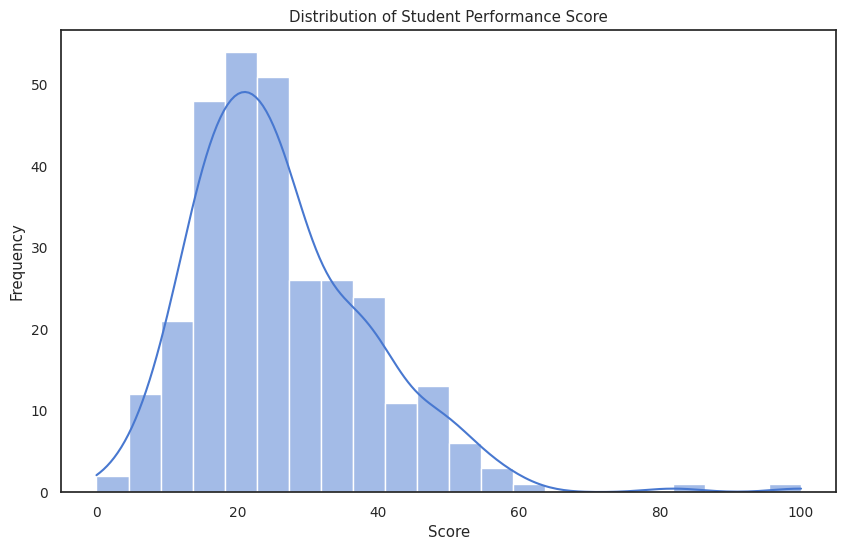

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(df['student_performance_score'], kde=True)
plt.title('Distribution of Student Performance Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show();

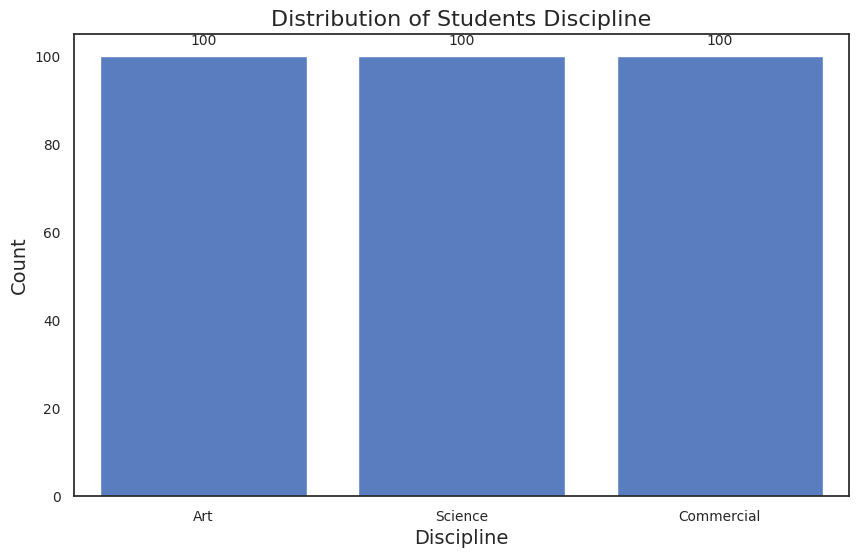

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='discipline')

# Add value annotations
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2, p.get_height() + 2),
                 ha='center', va='bottom', fontsize=10)

plt.xlabel('Discipline', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Students Discipline', fontsize=16)
plt.show();

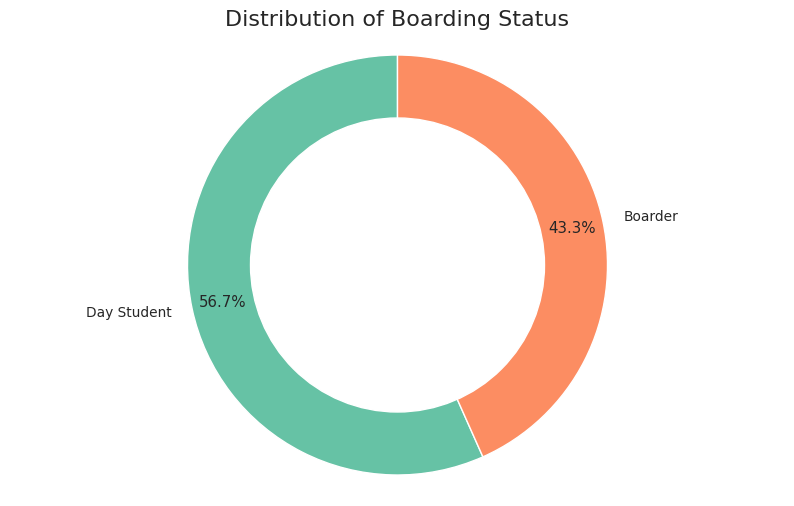

In [37]:
plt.figure(figsize=(10, 6))
boarding_counts = df['boarding_status'].value_counts()
plt.pie(boarding_counts, labels=boarding_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85, colors=sns.color_palette('Set2'))

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Boarding Status', fontsize=16)
plt.axis('equal')
plt.show();

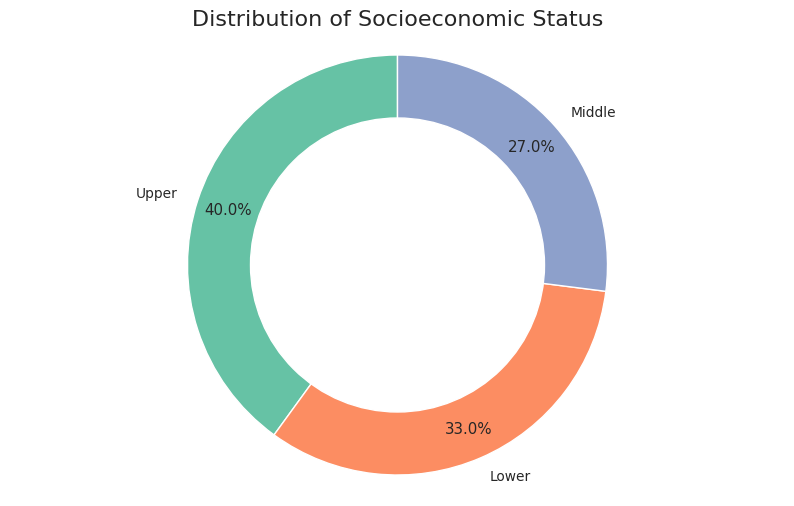

In [38]:
plt.figure(figsize=(10, 6))
socioeconomic_counts = df['socioeconomic_status'].value_counts()
plt.pie(socioeconomic_counts, labels=socioeconomic_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85, colors=sns.color_palette('Set2'))

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Socioeconomic Status', fontsize=16)
plt.axis('equal')
plt.show();

<ipython-input-39-a5534de67776>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='parent_education_level', palette='Set2')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a len

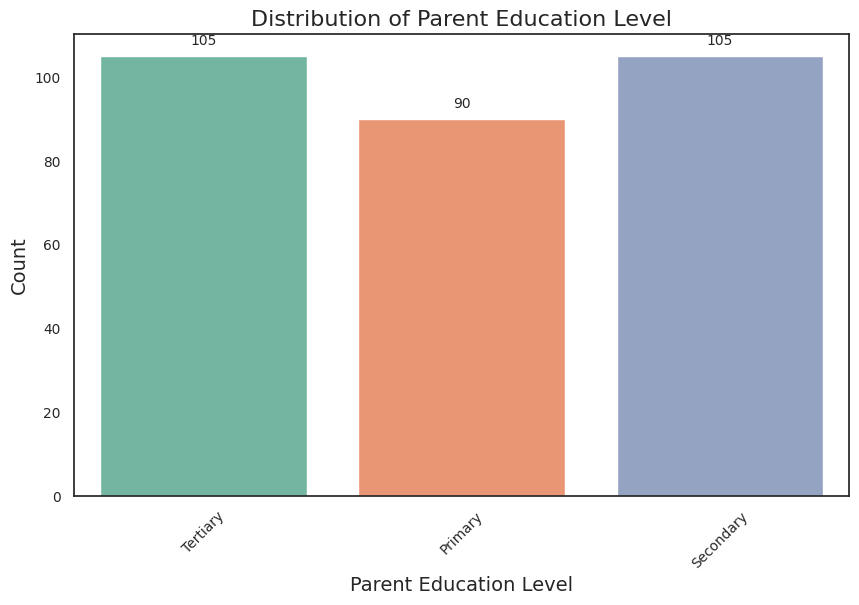

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='parent_education_level', palette='Set2')

for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2, p.get_height() + 2),
                 ha='center', va='bottom', fontsize=10)

plt.xlabel('Parent Education Level', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Parent Education Level', fontsize=16)
plt.xticks(rotation=45)
plt.show();

<ipython-input-40-2f3db990d4e7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='number_of_siblings', palette='Set2')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-

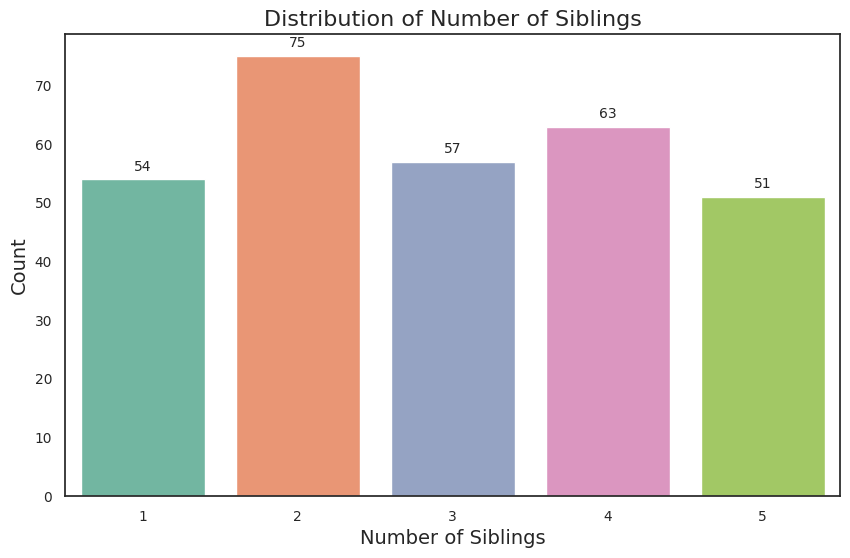

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='number_of_siblings', palette='Set2')

for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                 ha='center', va='bottom', fontsize=10)

plt.xlabel('Number of Siblings', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Number of Siblings', fontsize=16)
plt.show();

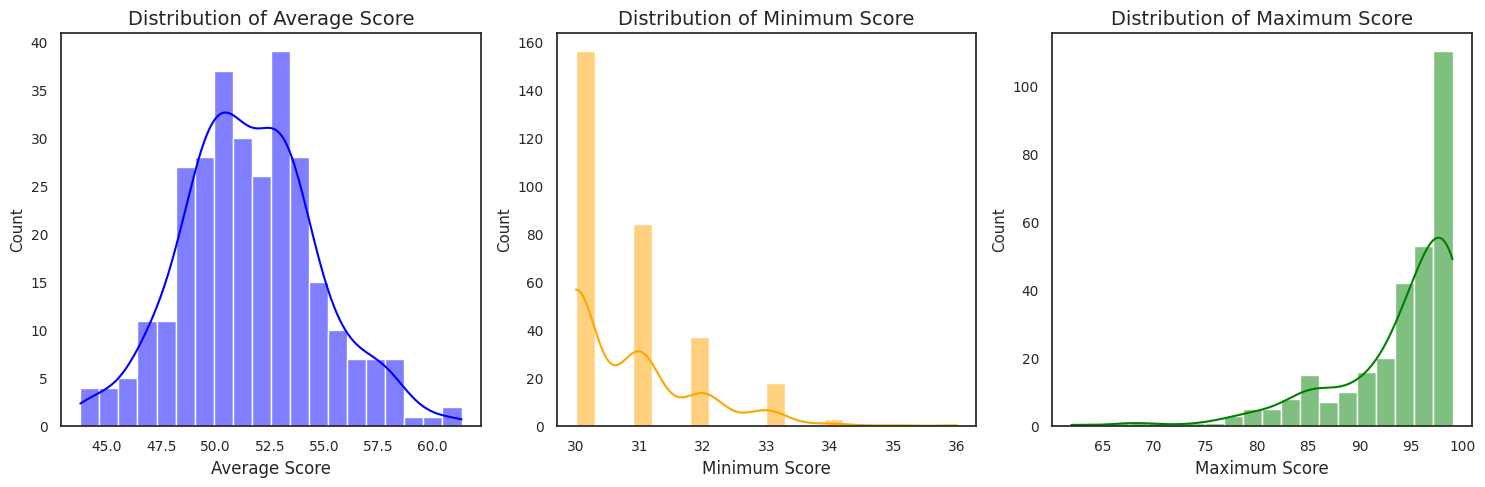

In [41]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['avg_score'], bins=20, color='blue', kde=True)
plt.xlabel('Average Score', fontsize=12)
plt.title('Distribution of Average Score', fontsize=14)

plt.subplot(1, 3, 2)
sns.histplot(df['min_score'], bins=20, color='orange', kde=True)
plt.xlabel('Minimum Score', fontsize=12)
plt.title('Distribution of Minimum Score', fontsize=14)

plt.subplot(1, 3, 3)
sns.histplot(df['max_score'], bins=20, color='green', kde=True)
plt.xlabel('Maximum Score', fontsize=12)
plt.title('Distribution of Maximum Score', fontsize=14)

plt.tight_layout()
plt.show();

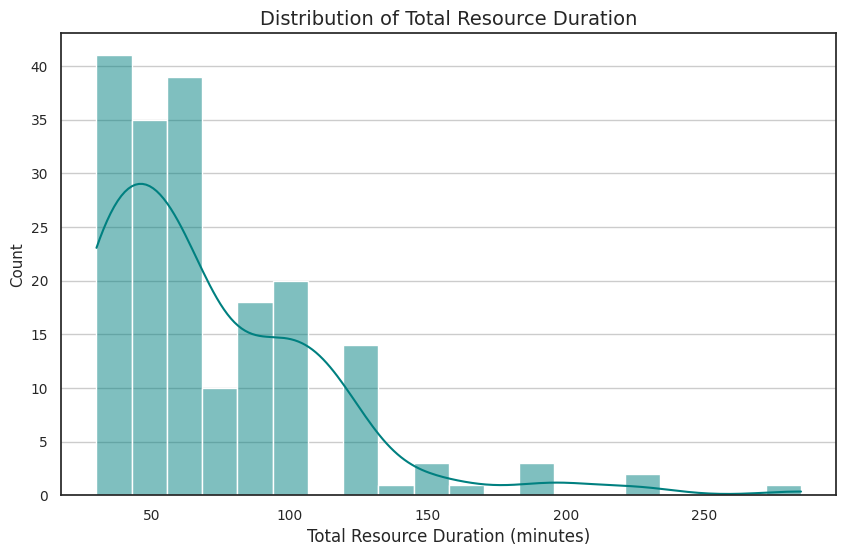

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(df['total_resource_duration'], bins=20, color='teal', kde=True)
plt.xlabel('Total Resource Duration (minutes)', fontsize=12)
plt.title('Distribution of Total Resource Duration', fontsize=14)
plt.grid(axis='y')
plt.show();

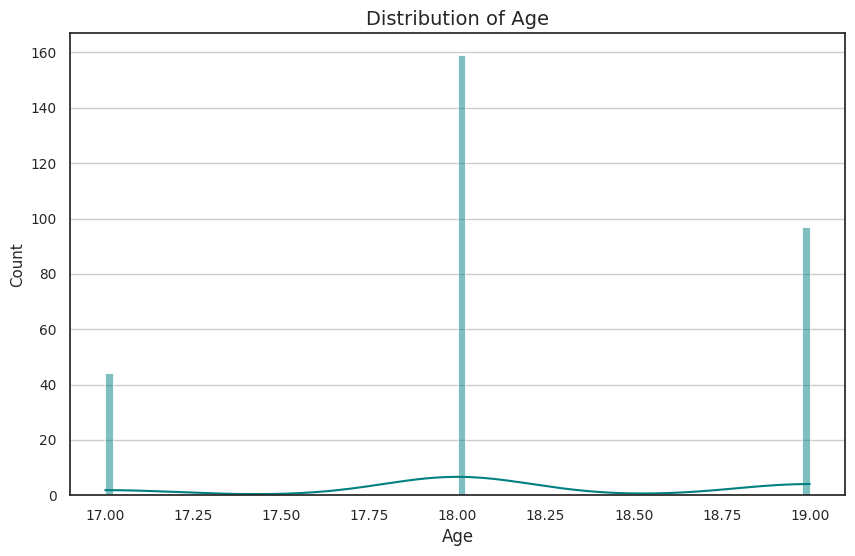

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=90, color='teal', kde=True)
plt.xlabel('Age', fontsize=12)
plt.title('Distribution of Age', fontsize=14)
plt.grid(axis='y')
plt.show();

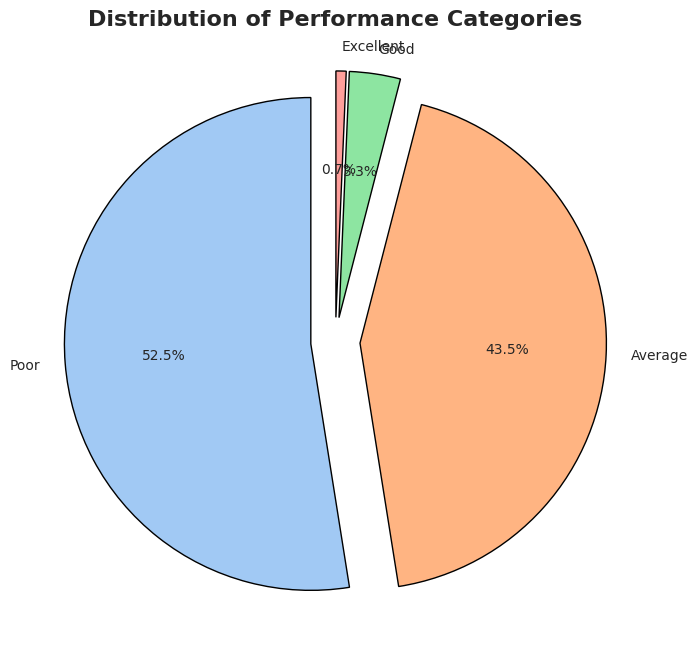

In [44]:
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
performance_counts = df['performance_category'].value_counts()
explode = [0.1] * len(performance_counts)

performance_counts.plot.pie(
    autopct='%1.1f%%', startangle=90, colors=colors,
    wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 10},
    explode=explode
)

plt.title('Distribution of Performance Categories', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.show();

<h3 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
   Bivariate & Multivariate Analysis
</h3>

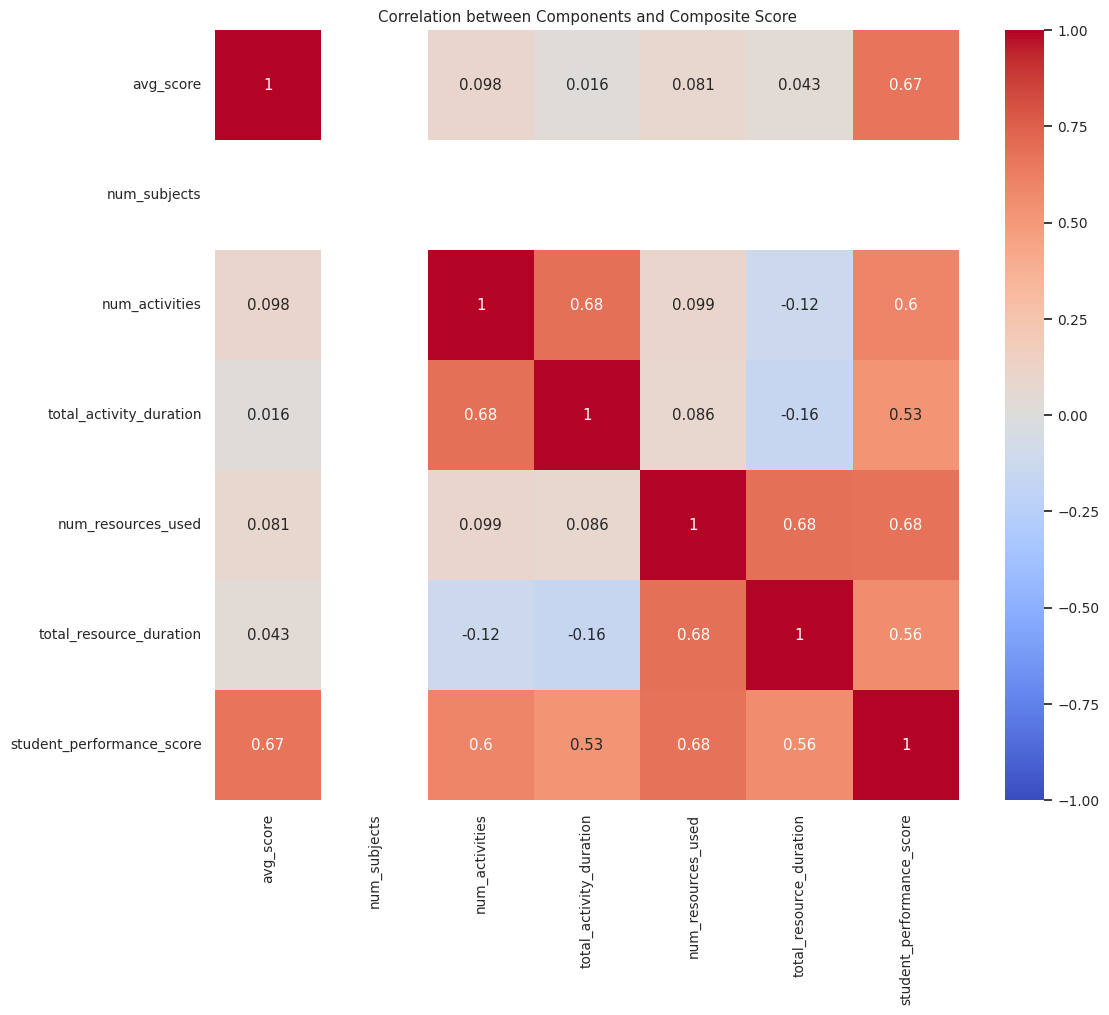


Correlation with Student Performance Score:
student_performance_score    1.000000
num_resources_used           0.675167
avg_score                    0.668599
num_activities               0.599017
total_resource_duration      0.556777
total_activity_duration      0.526417
num_subjects                      NaN
Name: student_performance_score, dtype: float64


In [45]:
#-----------------------------------------Correlation analysis-------------------------------------------------------------------#
correlation_matrix = df[components + ['student_performance_score']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between Components and Composite Score')
plt.show()

print("\nCorrelation with Student Performance Score:")
print(correlation_matrix['student_performance_score'].sort_values(ascending=False))

In [28]:
df=df[~df['performance_category'].isna()]

<h2 style="text-align: left; font-family: Arial, sans-serif; color: #ffffff; font-weight: bold; margin-top: 20px;">
   Machine Learning Model Development
</h2>

In [30]:
X = df[['total_attendance', 'total_resource_duration', 'health_information', 'socioeconomic_status', 'parent_education_level', 'number_of_siblings','family_structure','transport_mode','qualification','years_experience','boarding_status','avg_score']]

y = df['performance_category']

print(X.shape, y.shape)

(9970, 12) (9970,)


In [31]:
# Convert NaN values in categorical columns to 'nan'
cat_columns = X.select_dtypes(include=['object']).columns
X[cat_columns] = X[cat_columns].fillna('missing')
cat_features = np.where(X.dtypes == object)[0]

<ipython-input-31-71be55506018>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_columns] = X[cat_columns].fillna('missing')


In [32]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Split the dataset into training and testing sets
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Define the optimizer class
class RobustCatBoostOptimizer:
    def __init__(self, X_train, y_train, num_folds=5, max_evals=100, cat_features=None):
        self.X_train = X_train
        self.y_train = y_train
        self.num_folds = min(num_folds, min(y_train.value_counts()))
        self.max_evals = max_evals
        self.cat_features = cat_features
        self.best_score = 0
        self.best_params = None
        self.eval_counter = 0

        # Encode target variable
        self.le = LabelEncoder()
        self.y_train_encoded = self.le.fit_transform(self.y_train)
        self.num_class = len(self.le.classes_)

    def objective(self, params):
        self.eval_counter += 1
        params = self._process_params(params)

        model = CatBoostClassifier(**params, verbose=0)

        # Use cross_val_predict to get predictions for all samples
        y_pred = cross_val_predict(model, self.X_train, self.y_train_encoded, cv=self.num_folds, method='predict')
        y_pred_proba = cross_val_predict(model, self.X_train, self.y_train_encoded, cv=self.num_folds, method='predict_proba')

        metrics = {
            'accuracy': accuracy_score(self.y_train_encoded, y_pred),
            'f1_macro': f1_score(self.y_train_encoded, y_pred, average='macro'),
            'precision_macro': precision_score(self.y_train_encoded, y_pred, average='macro'),
            'recall_macro': recall_score(self.y_train_encoded, y_pred, average='macro'),
            'roc_auc_ovr': roc_auc_score(self.y_train_encoded, y_pred_proba, multi_class='ovr', average='macro')
        }

        logger.info(f"Eval {self.eval_counter}: Accuracy = {metrics['accuracy']:.4f}, "
                    f"F1 Macro = {metrics['f1_macro']:.4f}, "
                    f"ROC AUC OvR = {metrics['roc_auc_ovr']:.4f}")

        if metrics['accuracy'] > self.best_score:
            self.best_score = metrics['accuracy']
            self.best_params = params
            logger.info(f"New best score: {self.best_score:.4f}")
            logger.info(f"Best params: {self.best_params}")

        return {'loss': -metrics['accuracy'], 'status': STATUS_OK, **metrics}

    def _process_params(self, params):
        return {
            'iterations': int(params['iterations']),
            'depth': int(params['depth']),
            'learning_rate': params['learning_rate'],
            'l2_leaf_reg': params['l2_leaf_reg'],
            'border_count': int(params['border_count']),
            'random_strength': params['random_strength'],
            'task_type': 'CPU',
            'loss_function': 'MultiClass',
            'eval_metric': 'MultiClass',
            'random_seed': 42,
            'cat_features': self.cat_features,
        }

    def optimize(self):
        space = {
            'iterations': hp.quniform('iterations', 100, 600, 50),
            'depth': hp.quniform('depth', 4, 10, 1),
            'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
            'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(1), np.log(10)),
            'border_count': hp.quniform('border_count', 32, 255, 1),
            'random_strength': hp.loguniform('random_strength', np.log(1e-8), np.log(10)),
            #'grow_policy': hp.choice('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
        }

        trials = Trials()
        best = fmin(fn=self.objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=self.max_evals,
                    trials=trials,
                    rstate=np.random.default_rng(42))

        logger.info(f"Optimization completed. Best accuracy: {self.best_score:.4f}")
        logger.info(f"Best hyperparameters: {self.best_params}")

        return self.best_params, trials

def train_final_model(X_train, y_train, best_params, cat_features=None):
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)

    model = CatBoostClassifier(**best_params, verbose=0, cat_features=cat_features)
    model.fit(X_train, y_train_encoded, verbose=False)

    y_pred = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_train)

    metrics = {
        'accuracy': accuracy_score(y_train_encoded, y_pred),
        'f1_macro': f1_score(y_train_encoded, y_pred, average='macro'),
        'precision_macro': precision_score(y_train_encoded, y_pred, average='macro'),
        'recall_macro': recall_score(y_train_encoded, y_pred, average='macro'),
        'roc_auc_ovr': roc_auc_score(y_train_encoded, y_pred_proba, multi_class='ovr', average='macro')
    }

    logger.info("Final Model Performance (Training Data):")
    for metric, value in metrics.items():
        logger.info(f"{metric}: {value:.4f}")

    return model, metrics


In [33]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42)

In [34]:

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get unique classes from target variable
unique_classes = y.unique()  # Get unique classes from your target variable 'y'

# Loop over each fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create Pool objects for training and testing
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)

    # Define the CatBoostClassifier model
    clf = CatBoostClassifier(
        loss_function='MultiClass',  # Changed to MultiClass for multi-class classification
        eval_metric='Accuracy',  # Changed to a suitable metric for multi-class classification
        iterations=500,
        # Use unique_classes instead of hardcoded class names
        class_names=unique_classes.tolist(),  # Convert to list if necessary
        cat_features=cat_features,
        verbose=50
    )

    # Fit the model
    clf.fit(train_pool, eval_set=test_pool, metric_period=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.146675
0:	learn: 0.8706118	test: 0.8605817	best: 0.8605817 (0)	total: 114ms	remaining: 56.8s
50:	learn: 0.9969910	test: 0.9984955	best: 0.9984955 (50)	total: 3.7s	remaining: 32.6s
100:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 7.54s	remaining: 29.8s
150:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 11.6s	remaining: 26.9s
200:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 14.4s	remaining: 21.4s
250:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 17.1s	remaining: 16.9s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 20.2s	remaining: 13.3s
350:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 24.2s	remaining: 10.3s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 26.8s	remaining: 6.62s
450:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 29.4s	remaining: 3.19s
499:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 31.9s	remaining: 0u

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.146675
0:	learn: 0.8674774	test: 0.8731194	best: 0.8731194 (0)	total: 68.8ms	remaining: 34.3s
50:	learn: 0.9884654	test: 0.9884654	best: 0.9884654 (50)	total: 4.7s	remaining: 41.4s
100:	learn: 0.9998746	test: 1.0000000	best: 1.0000000 (90)	total: 7.55s	remaining: 29.8s
150:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (90)	total: 10.3s	remaining: 23.7s
200:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (90)	total: 12.9s	remaining: 19.2s
250:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (90)	total: 16.6s	remaining: 16.5s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (90)	total: 20s	remaining: 13.2s
350:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (90)	total: 22.7s	remaining: 9.65s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (90)	total: 25.4s	remaining: 6.26s
450:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (90)	total: 29.8s	remaining: 3.23s
499:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (90)	total: 33.5s	remaining: 0us

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.146675
0:	learn: 0.8665998	test: 0.8766299	best: 0.8766299 (0)	total: 59.4ms	remaining: 29.7s
50:	learn: 0.9938566	test: 0.9959880	best: 0.9959880 (50)	total: 3.04s	remaining: 26.8s
100:	learn: 0.9996239	test: 1.0000000	best: 1.0000000 (60)	total: 5.88s	remaining: 23.2s
150:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 8.86s	remaining: 20.5s
200:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 13.2s	remaining: 19.7s
250:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 16s	remaining: 15.9s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 18.8s	remaining: 12.5s
350:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 21.6s	remaining: 9.17s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 26.1s	remaining: 6.45s
450:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 28.9s	remaining: 3.13s
499:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 31.5s	remaining: 0u

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.146675
0:	learn: 0.8707372	test: 0.8600802	best: 0.8600802 (0)	total: 61.7ms	remaining: 30.8s
50:	learn: 0.9942327	test: 0.9959880	best: 0.9959880 (50)	total: 2.99s	remaining: 26.4s
100:	learn: 0.9994985	test: 1.0000000	best: 1.0000000 (60)	total: 7.34s	remaining: 29s
150:	learn: 0.9997492	test: 1.0000000	best: 1.0000000 (60)	total: 10.1s	remaining: 23.3s
200:	learn: 0.9998746	test: 1.0000000	best: 1.0000000 (60)	total: 13.3s	remaining: 19.8s
250:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 16s	remaining: 15.9s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 19.7s	remaining: 13s
350:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 22.8s	remaining: 9.7s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 25.5s	remaining: 6.29s
450:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 28.1s	remaining: 3.05s
499:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (60)	total: 30.6s	remaining: 0us

be

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.146675
0:	learn: 0.8688566	test: 0.8676028	best: 0.8676028 (0)	total: 63.5ms	remaining: 31.7s
50:	learn: 0.9915998	test: 0.9934804	best: 0.9934804 (50)	total: 4.7s	remaining: 41.3s
100:	learn: 0.9998746	test: 1.0000000	best: 1.0000000 (70)	total: 7.52s	remaining: 29.7s
150:	learn: 0.9998746	test: 1.0000000	best: 1.0000000 (70)	total: 10.3s	remaining: 23.9s
200:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (70)	total: 13.2s	remaining: 19.6s
250:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (70)	total: 17.6s	remaining: 17.4s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (70)	total: 20.1s	remaining: 13.3s
350:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (70)	total: 22.7s	remaining: 9.66s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (70)	total: 25.3s	remaining: 6.25s
450:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (70)	total: 28.3s	remaining: 3.08s
499:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (70)	total: 32.2s	remaining: 0

In [37]:
# Retrain the final model on the entire dataset
final_train_pool = Pool(X, y, cat_features=cat_features)
final_clf = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='Accuracy',
    iterations=500,
    class_names=unique_classes.tolist(),
    cat_features=cat_features,
    verbose=50
)

final_clf.fit(final_train_pool, verbose=50)

# Save the final model using pickle
import pickle
with open('catboost_agg_model.pkl', 'wb') as file:
    pickle.dump(final_clf, file)

print("Final model saved as 'catboost_agg_model.pkl'")

Learning rate set to 0.159818
0:	learn: 0.8495486	total: 106ms	remaining: 53.1s
50:	learn: 0.9897693	total: 5.17s	remaining: 45.5s
100:	learn: 0.9993982	total: 8.36s	remaining: 33s
150:	learn: 0.9998997	total: 11.5s	remaining: 26.5s
200:	learn: 1.0000000	total: 15.5s	remaining: 23s
250:	learn: 1.0000000	total: 19.4s	remaining: 19.2s
300:	learn: 1.0000000	total: 22.5s	remaining: 14.9s
350:	learn: 1.0000000	total: 25.6s	remaining: 10.9s
400:	learn: 1.0000000	total: 29.8s	remaining: 7.36s
450:	learn: 1.0000000	total: 33.4s	remaining: 3.63s
499:	learn: 1.0000000	total: 36.3s	remaining: 0us
Final model saved as 'catboost_agg_model.pkl'
